In [1]:
!pip install polars beautifulsoup4 splinter selenium scikit-learn matplotlib altair seaborn vl-convert-python tensorflow keras-tuner pandas pyarrow

In [2]:
#Data Manipulation and display toools
import polars as pl
from polars.exceptions import InvalidOperationError
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pathlib
# Pandas is necessary for ease of use with the ML libraries
# Polars does not use indexing and therefore does not always follow the data format properly
# Particularly the format:
#   {tablename: {index_val1: [row1_values]},
#               {index_val2: [row2_values]}}
import pandas as pd
# pyarrow necessary for polars.to_pandas() used in corr plots
import pyarrow
# Used to Display 2 dataframes next to eachother
from IPython.display import display_html 

# Web scraping tools
import re

# Data preprocessing tools
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.utils.fixes import parse_version


# Machine learning tools
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import classification_report, accuracy_score, r2_score

#Necessary for tensorflow on my machine due to distutils being depreciated
import setuptools
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import Model, Sequential
from tensorflow.keras import optimizers
import keras_tuner as kt

random_state = 1

2024-11-25 12:16:44.273512: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-25 12:16:44.273900: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-25 12:16:44.275654: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-25 12:16:44.280685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732565804.289152   65803 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732565804.29

# Overview of revisted Goals

Remove the multioutput model work

Remove the web scraping component, it does not add sufficent data for the performance loss

Remove one hot encoding of steel type. Does not add additional information over atomic composition.

1. Address multicollinearity in a way that preserves physical world explainability
   *Remove PCA or correlate with PCA dimensionality projection.
2. Implement pipelines through sklearn or tf
   * Able to intake a new row and output a hardness  
3. Implement the business case function suggested in the proposal.
   * Use a search algorythem to find conditions that predict the desired final hardness from a metal.

# Loading Data

In [3]:
cwd = pathlib.Path.cwd()

if cwd.name == 'Mild-Steel-Tempering':
    print("Path is project root")
else:
    print("Please correct current working directory to the project root")


Path is project root


In [4]:
resources_path = pathlib.PurePath(pathlib.PurePath(cwd), 'resources', 'revised')
resources_path

PurePosixPath('/home/mox/Documents/coding_projects/bootcamp_local/Homeworks/Mild-Steel-Tempering/resources/revised')

In [5]:
images_path = pathlib.PurePath(pathlib.PurePath(cwd), 'images', 'revised')
images_path

PurePosixPath('/home/mox/Documents/coding_projects/bootcamp_local/Homeworks/Mild-Steel-Tempering/images/revised')

### Many alloy composition columns were parsed incorrectly and failing to load

Several weight percent columns were parsed as int automatically due to having "0" for many initial rows. 

All weight percent columns should be parsed as float. 

In [6]:
data_path = f"{resources_path.parent}/Raiipa-tempering-data.csv"
schema_overrides = {"C (%wt)" : pl.Float64,
"Mn (%wt)" : pl.Float64,
"P (%wt)" : pl.Float64,
"S (%wt)" : pl.Float64,
"Si (%wt)" : pl.Float64,
"Ni (%wt)" : pl.Float64,
"Cr (%wt)" : pl.Float64,
"Mo (%wt)" : pl.Float64,
"V (%wt)" : pl.Float64,
"Al (%wt)" : pl.Float64,
"Cu (%wt)" : pl.Float64}

df_data = pl.read_csv(data_path, schema_overrides=schema_overrides)
df_data.glimpse()

Rows: 1466
Columns: 17
$ Source                                  <str> 'Grange and Baughman, 1956', 'Grange and Baughman, 1956', 'Grange and Baughman, 1956', 'Grange and Baughman, 1956', 'Grange and Baughman, 1956', 'Grange and Baughman, 1956', 'Grange and Baughman, 1956', 'Grange and Baughman, 1956', 'Grange and Baughman, 1956', 'Grange and Baughman, 1956'
$ Steel type                              <str> 'AISI-SAE 1026', 'AISI-SAE 1026', 'AISI-SAE 1026', 'AISI-SAE 1026', 'AISI-SAE 1026', 'AISI-SAE 1026', 'AISI-SAE 1026', 'AISI-SAE 1026', 'AISI-SAE 1026', 'AISI-SAE 1026'
$ Initial hardness (HRC) - post quenching <str> '?', '?', '?', '?', '?', '?', '?', '?', '?', '?'
$ Tempering time (s)                      <i64> 600, 600, 600, 600, 600, 600, 600, 600, 600, 600
$ Tempering temperature (ºC)              <f64> 204.4, 260.0, 315.6, 371.1, 426.7, 482.2, 537.8, 593.3, 648.9, 704.4
$ C (%wt)                                 <f64> 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25
$ Mn 

In [7]:
# save initial columns names as they are very descriptive and may be useful later
initial_column_names = df_data.columns
initial_column_names

['Source',
 'Steel type',
 'Initial hardness (HRC) - post quenching',
 'Tempering time (s)',
 'Tempering temperature (ºC)',
 'C (%wt)',
 'Mn (%wt)',
 'P (%wt)',
 'S (%wt)',
 'Si (%wt)',
 'Ni (%wt)',
 'Cr (%wt)',
 'Mo (%wt)',
 'V (%wt)',
 'Al (%wt)',
 'Cu (%wt)',
 'Final hardness (HRC) - post tempering']

# Cleaning
Many columns need renaming for ease of manipulation

Columns need datatypes correction
 'Initial hardness (HRC) - post quenching' needs datatype correction. ? is NA value


In [8]:
dict_new_cnames = {}
for og_name in initial_column_names:
    # replace filler in hardness columns
    new_name = og_name.replace(' - ', '')
    
    # Handle units
    try:
        #if alloy weight percent remove units and return only elemental symbol
        if re.search(r"\(%wt\)", og_name):
            new_name = og_name.split(' ')[0]
            #skip the rest of the try block that will re_add the units to the end
            pass
        else: 
            #If not elemental composition, lowercase the string
            new_name = new_name.lower()
        # regex find the units inside the parenthesis, of the original name, not the lowercased new name
        # This lines breaks and goes to except if there is no units
        unit = re.search(r'\((\w+)\)', og_name).group(1)
        # replace the unit parenthesis string with parenthesis with an empty string
        new_name = re.sub(r"\(.+\)", "", new_name)
        # trim to whitespace end characters left by some unit removals
        new_name = new_name.rstrip()
        # append the unit string to the end of the processed name
        new_name = f"{new_name}_{unit}"
    except:
        # skip unit processing on names with no units denoted by parenthesis
        pass

    # Strip away special characters
    new_name = new_name.encode("ascii", errors="ignore").decode()
    #replace all whitespace with underscores
    new_name = new_name.replace(' ', '_')
    #add the name to the rename dict
    dict_new_cnames[og_name] = new_name
dict_new_cnames


{'Source': 'source',
 'Steel type': 'steel_type',
 'Initial hardness (HRC) - post quenching': 'initial_hardness_post_quenching_HRC',
 'Tempering time (s)': 'tempering_time_s',
 'Tempering temperature (ºC)': 'tempering_temperature_C',
 'C (%wt)': 'C',
 'Mn (%wt)': 'Mn',
 'P (%wt)': 'P',
 'S (%wt)': 'S',
 'Si (%wt)': 'Si',
 'Ni (%wt)': 'Ni',
 'Cr (%wt)': 'Cr',
 'Mo (%wt)': 'Mo',
 'V (%wt)': 'V',
 'Al (%wt)': 'Al',
 'Cu (%wt)': 'Cu',
 'Final hardness (HRC) - post tempering': 'final_hardness_post_tempering_HRC'}

In [9]:
df_clean_cnames = df_data.rename(dict_new_cnames)

## Clean data types and column values

In [10]:
count_of_qmark = df_clean_cnames['initial_hardness_post_quenching_HRC'].value_counts()\
    .filter(pl.col('initial_hardness_post_quenching_HRC') == "?")\
        .select("count").item()


In [11]:
percent_intial_hardness_unknown = count_of_qmark / int(df_clean_cnames['initial_hardness_post_quenching_HRC'].shape[0])
print(f"Unknown initial hardness: {round(percent_intial_hardness_unknown, 2) * 100:.0f}%")


Unknown initial hardness: 65%


In [12]:
df_clean_cnames.tail(3)


source,steel_type,initial_hardness_post_quenching_HRC,tempering_time_s,tempering_temperature_C,C,Mn,P,S,Si,Ni,Cr,Mo,V,Al,Cu,final_hardness_post_tempering_HRC
str,str,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Hollomon and Jaffe, 1945""","""1,15%C - plain carbon steel""","""64.5""",86400,500.0,1.15,0.58,0.012,0.021,0.09,0.0,0.01,0.0,0.0,0.0,0.0,32.0
"""Hollomon and Jaffe, 1945""","""1,15%C - plain carbon steel""","""64.5""",86400,600.0,1.15,0.58,0.012,0.021,0.09,0.0,0.01,0.0,0.0,0.0,0.0,23.0
"""Hollomon and Jaffe, 1945""","""1,15%C - plain carbon steel""","""64.5""",86400,700.0,1.15,0.58,0.012,0.021,0.09,0.0,0.01,0.0,0.0,0.0,0.0,4.5


In [13]:
df_clean_cnames["initial_hardness_post_quenching_HRC"].value_counts().sort('count', descending=True).head(3)

initial_hardness_post_quenching_HRC,count
str,u32
"""?""",949
"""66.5""",90
"""55.8""",51


In [14]:
df_clean = df_clean_cnames.with_columns(pl.col('initial_hardness_post_quenching_HRC').cast(pl.Float64, strict=False))


In [15]:
df_clean["initial_hardness_post_quenching_HRC"].value_counts().sort('count', descending=True).head(3)

initial_hardness_post_quenching_HRC,count
f64,u32
null,949
66.5,90
55.8,51


In [16]:
df_clean.describe()

statistic,source,steel_type,initial_hardness_post_quenching_HRC,tempering_time_s,tempering_temperature_C,C,Mn,P,S,Si,Ni,Cr,Mo,V,Al,Cu,final_hardness_post_tempering_HRC
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1466""","""1466""",517.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0
"""null_count""","""0""","""0""",949.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,null,61.493617,21969.754434,422.024147,0.511583,0.74073,0.017236,0.023802,0.239379,0.362838,0.389696,0.080232,0.005457,0.034379,0.005986,41.468008
"""std""",null,null,5.656383,34177.623863,176.088041,0.224354,0.252913,0.007966,0.007967,0.239193,0.810091,0.480721,0.121422,0.02905,0.20534,0.019085,14.079248
"""min""","""Grange and Baughman, 1956""","""0,31%C - plain carbon steel""",46.5,10.0,100.0,0.25,0.3,0.007,0.005,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.9
"""25%""",null,null,58.8,600.0,260.0,0.37,0.6,0.012,0.018,0.16,0.0,0.02,0.0,0.0,0.0,0.0,32.1
"""50%""",null,null,63.1,3600.0,426.7,0.42,0.74,0.017,0.024,0.21,0.01,0.06,0.0,0.0,0.0,0.0,43.1
"""75%""",null,null,66.5,14400.0,593.3,0.56,0.8,0.019,0.029,0.24,0.06,0.8,0.22,0.0,0.0,0.0,51.8
"""max""","""Penha, 2010""","""Nitriding Steel """,67.0,115200.0,704.4,1.15,1.85,0.054,0.055,1.62,3.41,1.57,0.36,0.16,1.26,0.08,68.5


# Set machine learning target

In [17]:
target_columns = ['final_hardness_post_tempering_HRC']

## Save data prior to ML preprocessing so that it may be used in the regression model 

In [18]:
#save pre-ML preprocessing data so that it can be loaded by the other file
combined_data = df_clean.clone()
combined_data.describe()


statistic,source,steel_type,initial_hardness_post_quenching_HRC,tempering_time_s,tempering_temperature_C,C,Mn,P,S,Si,Ni,Cr,Mo,V,Al,Cu,final_hardness_post_tempering_HRC
str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""","""1466""","""1466""",517.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0,1466.0
"""null_count""","""0""","""0""",949.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,null,61.493617,21969.754434,422.024147,0.511583,0.74073,0.017236,0.023802,0.239379,0.362838,0.389696,0.080232,0.005457,0.034379,0.005986,41.468008
"""std""",null,null,5.656383,34177.623863,176.088041,0.224354,0.252913,0.007966,0.007967,0.239193,0.810091,0.480721,0.121422,0.02905,0.20534,0.019085,14.079248
"""min""","""Grange and Baughman, 1956""","""0,31%C - plain carbon steel""",46.5,10.0,100.0,0.25,0.3,0.007,0.005,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.9
"""25%""",null,null,58.8,600.0,260.0,0.37,0.6,0.012,0.018,0.16,0.0,0.02,0.0,0.0,0.0,0.0,32.1
"""50%""",null,null,63.1,3600.0,426.7,0.42,0.74,0.017,0.024,0.21,0.01,0.06,0.0,0.0,0.0,0.0,43.1
"""75%""",null,null,66.5,14400.0,593.3,0.56,0.8,0.019,0.029,0.24,0.06,0.8,0.22,0.0,0.0,0.0,51.8
"""max""","""Penha, 2010""","""Nitriding Steel """,67.0,115200.0,704.4,1.15,1.85,0.054,0.055,1.62,3.41,1.57,0.36,0.16,1.26,0.08,68.5


In [19]:
# Al was only present in nitriding steel which was removed ealier on as additional features could not be attributed to it
combined_data.write_csv(f'{resources_path}/all_cols.csv')
combined_data.columns

['source',
 'steel_type',
 'initial_hardness_post_quenching_HRC',
 'tempering_time_s',
 'tempering_temperature_C',
 'C',
 'Mn',
 'P',
 'S',
 'Si',
 'Ni',
 'Cr',
 'Mo',
 'V',
 'Al',
 'Cu',
 'final_hardness_post_tempering_HRC']

# Checking feature correlation

There is some degree of correleation, especially negative correlations enough that a mitigation measures for multicolinearity should be taken. PCA will be done later

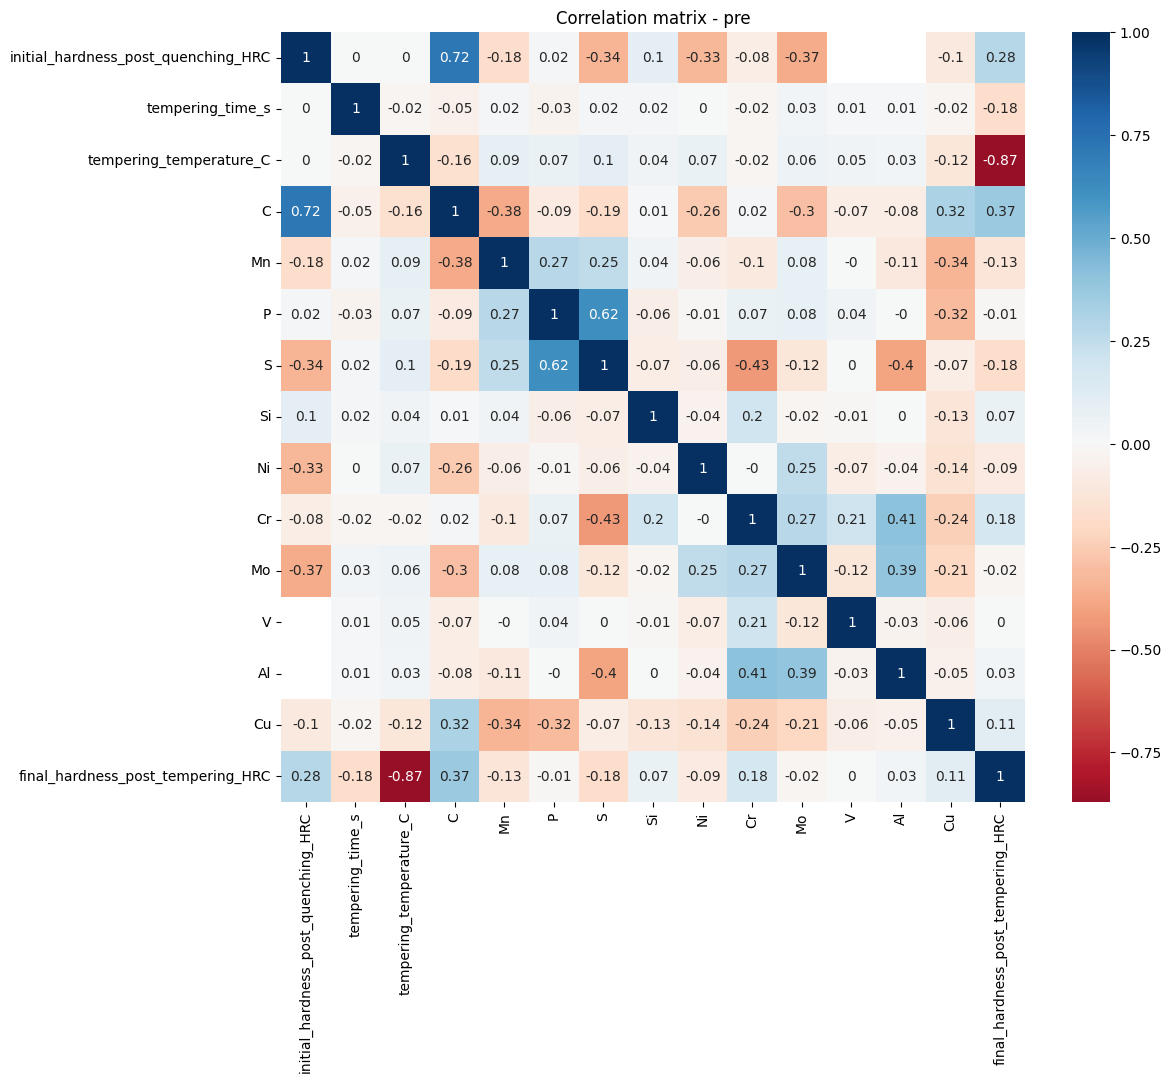

In [20]:
corr_data = pd.read_csv(f'{resources_path}/all_cols.csv')

df_corr = corr_data.corr(numeric_only=True).round(2)

plt.figure(figsize=(12, 10))
plot_corr = sns.heatmap(df_corr, annot=True, cmap='RdBu', center=0)

plt.title('Correlation matrix - pre')
plt.savefig(f'{images_path}/corr.png', bbox_inches='tight')

# Preprocess data

All columns are numeric

Soure dropped as it has no physical meaning

steel_type dropped because it encodes elemental composition as human readable

initial_hardness dropped as it has missing values for 60% of rows, and no way to sensibly predict values. Insertion of a mean or median or other factor would result in wildly incorrect synthetic data.

# Normalize variables

Almost all colums have a high degree of skew.

Will be addressed through Yeo-Johnson methods.

In [21]:
to_normalize = combined_data.drop(['source','steel_type', 'initial_hardness_post_quenching_HRC'])
to_normalize.tail(3)

tempering_time_s,tempering_temperature_C,C,Mn,P,S,Si,Ni,Cr,Mo,V,Al,Cu,final_hardness_post_tempering_HRC
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
86400,500.0,1.15,0.58,0.012,0.021,0.09,0.0,0.01,0.0,0.0,0.0,0.0,32.0
86400,600.0,1.15,0.58,0.012,0.021,0.09,0.0,0.01,0.0,0.0,0.0,0.0,23.0
86400,700.0,1.15,0.58,0.012,0.021,0.09,0.0,0.01,0.0,0.0,0.0,0.0,4.5


In [22]:
columns = to_normalize.columns
alt.Chart(to_normalize).mark_bar().encode(
    alt.X(alt.repeat('repeat'), bin=True),
    y='count()'
).repeat(
    repeat = columns
)

alt.RepeatChart(...)

In [23]:
def present_skewness_per_col(data, skew_cutoff= 1, columns= columns, output=True):
    no_skew = []
    skewed = []
    if output:
        print('column', 'skew') 
        print('-----------')
    for col in columns:
        skew = round(data[col].skew(), 2)
        if output:
            print(col, skew) 

        if np.absolute(skew) < skew_cutoff:
            no_skew.append(col)
        else:
            skewed.append(col)
    if output:
        print('count skewed:', len(skewed))
        print('count not skewed:', len(no_skew))
    else:
        return skewed

In [24]:
present_skewness_per_col(to_normalize)

column skew
-----------
tempering_time_s 1.48
tempering_temperature_C -0.06
C 1.41
Mn 2.59
P 2.27
S 0.65
Si 5.21
Ni 2.37
Cr 0.85
Mo 1.01
V 5.13
Al 5.8
Cu 2.98
final_hardness_post_tempering_HRC -0.39
count skewed: 10
count not skewed: 4


In [25]:
skewed = present_skewness_per_col(to_normalize, skew_cutoff=0.5, output=False)

In [26]:
p_ct_fix_skew = ColumnTransformer(transformers=[('yeo_johnson', PowerTransformer(), skewed)],
                                  remainder= 'passthrough')

normalized = p_ct_fix_skew.fit_transform(to_normalize.to_pandas())

In [27]:
normalized_inames = pl.DataFrame(normalized)
ninames_colnames = normalized_inames.columns
normalized = normalized_inames.rename(dict(zip(ninames_colnames, columns)))
normalized

tempering_time_s,tempering_temperature_C,C,Mn,P,S,Si,Ni,Cr,Mo,V,Al,Cu,final_hardness_post_tempering_HRC
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.712928,-2.092432,0.407486,-0.738517,0.343825,-1.379669,-0.659269,-0.963099,-0.706132,-0.187912,-0.167483,-0.318477,204.4,50.6
-0.712928,-2.092432,0.407486,-0.738517,0.343825,-1.379669,-0.659269,-0.963099,-0.706132,-0.187912,-0.167483,-0.318477,260.0,48.3
-0.712928,-2.092432,0.407486,-0.738517,0.343825,-1.379669,-0.659269,-0.963099,-0.706132,-0.187912,-0.167483,-0.318477,315.6,43.7
-0.712928,-2.092432,0.407486,-0.738517,0.343825,-1.379669,-0.659269,-0.963099,-0.706132,-0.187912,-0.167483,-0.318477,371.1,40.5
-0.712928,-2.092432,0.407486,-0.738517,0.343825,-1.379669,-0.659269,-0.963099,-0.706132,-0.187912,-0.167483,-0.318477,426.7,37.3
…,…,…,…,…,…,…,…,…,…,…,…,…,…
1.438707,1.875515,-0.687525,-0.738517,-0.300489,-1.794359,-0.659269,-0.900069,-0.706132,-0.187912,-0.167483,-0.318477,300.0,50.5
1.438707,1.875515,-0.687525,-0.738517,-0.300489,-1.794359,-0.659269,-0.900069,-0.706132,-0.187912,-0.167483,-0.318477,400.0,42.0
1.438707,1.875515,-0.687525,-0.738517,-0.300489,-1.794359,-0.659269,-0.900069,-0.706132,-0.187912,-0.167483,-0.318477,500.0,32.0


In [ ]:
alt.Chart(to_normalize).mark_bar().encode(
    alt.X(alt.repeat('repeat'), bin=True),
    y='count()'
).repeat(
    repeat = columns
).save()

alt.RepeatChart(...)

In [29]:
alt.Chart(normalized).mark_bar().encode(
    alt.X(alt.repeat('repeat'), bin=True),
    y='count()'
).repeat(
    repeat = columns
)

alt.RepeatChart(...)

In [30]:
present_skewness_per_col(normalized)

column skew
-----------
tempering_time_s -0.08
tempering_temperature_C 0.19
C -0.19
Mn -0.02
P -0.05
S -0.15
Si 1.45
Ni 0.46
Cr 0.84
Mo 5.13
V 5.8
Al 2.82
Cu -0.06
final_hardness_post_tempering_HRC -0.39
count skewed: 4
count not skewed: 10


## Normalization successful

Down from 10 with high skew to 4 out of 14 columns

Viewing the 4 columns that retained high skew, the data is essentially binary, on a continuos scale

## Scale numerical columns 

All columns are numeric and range from 0.0# to 1000 so scaling is necessary

This will ensure the small elemental composition values are not overshadowed by the large strength properties 

y is not scaled as it is normalized and a single target column

In [75]:
to_scale = normalized.clone()

In [76]:
to_scale_X = to_scale.drop(target_columns)
y = to_scale.select(target_columns)

In [77]:
def get_scaler_rename_dict(data_scaler):
    scaler_names = data_scaler.get_feature_names_out()
    columns = [f'column_{n}' for n in range(len(scaler_names))]
    rename_dict = dict(zip(columns, scaler_names))
    return rename_dict

def std_scale_data(to_scale):
    scaler = StandardScaler()
    d_scaled = scaler.fit_transform(to_scale)
    rename_dict = get_scaler_rename_dict(scaler)
    return (pl.DataFrame(d_scaled).rename(rename_dict), scaler)
    

In [78]:
df_scaled_X, scaler_X = std_scale_data(to_scale_X)
df_scaled_X.tail(3)


tempering_time_s,tempering_temperature_C,C,Mn,P,S,Si,Ni,Cr,Mo,V,Al,Cu
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.438707,1.875515,-0.687525,-0.738517,-0.300489,-1.794359,-0.659269,-0.900069,-0.706132,-0.187912,-0.167483,-0.318477,0.442974
1.438707,1.875515,-0.687525,-0.738517,-0.300489,-1.794359,-0.659269,-0.900069,-0.706132,-0.187912,-0.167483,-0.318477,1.011066
1.438707,1.875515,-0.687525,-0.738517,-0.300489,-1.794359,-0.659269,-0.900069,-0.706132,-0.187912,-0.167483,-0.318477,1.579157


In [79]:
columns = df_scaled_X.columns
alt.Chart(df_scaled_X).mark_bar().encode(
    alt.X(alt.repeat('repeat'), bin=True),
    y='count()'
).repeat(
    repeat = columns
)

alt.RepeatChart(...)

In [80]:
df_scaled_X.write_csv(f"{resources_path}/df_X.csv")
y.write_csv(f"{resources_path}/df_y.csv")

# Modelling

In [81]:
X = pl.read_csv(f'{resources_path}/df_X.csv')
y = pl.read_csv(f'{resources_path}/df_y.csv',   
                schema={'final_hardness_post_tempering_HRC': pl.Float32})
print(y)
# Polars does not always work well with Keras
X = X.to_numpy()
y = y.to_numpy()
y

shape: (1_466, 1)
┌─────────────────────────────────┐
│ final_hardness_post_tempering_… │
│ ---                             │
│ f32                             │
╞═════════════════════════════════╡
│ 50.599998                       │
│ 48.299999                       │
│ 43.700001                       │
│ 40.5                            │
│ 37.299999                       │
│ …                               │
│ 50.5                            │
│ 42.0                            │
│ 32.0                            │
│ 23.0                            │
│ 4.5                             │
└─────────────────────────────────┘


array([[50.6],
       [48.3],
       [43.7],
       ...,
       [32. ],
       [23. ],
       [ 4.5]], dtype=float32)

## Test train split

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=random_state)
                                                    # stratify=y)

# Transition to regression single target

Target final hardness, include tempering process as data

## Gradient boost regression

The final hardness is a continuos varaible, that may be non-linear with respect to the supporting features. 

### This model does perform well, r2 = 0.93

I will attmpt to use neural network modelling to see if it can be improved, and to get history.


In [83]:
gb_regressor = GradientBoostingRegressor(random_state=random_state)

gb_regressor.fit(X_train, y_train)


/home/mox/Documents/coding_projects/bootcamp_local/Homeworks/Mild-Steel-Tempering/.venv/lib/python3.12/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GradientBoostingRegressor(random_state=1)

In [84]:
y_pred = gb_regressor.predict(X_test)
y_pred.shape

(367,)

In [95]:
# match y_test shape to model output shape
def reshape_y_to_1d(y_test):
    return y_test.reshape(1,-1)[0]

In [96]:
print("R2 score:", round(gb_regressor.score(X_test, reshape_y_to_1d(y_test)), 5))

R2 score: 0.98038


In [97]:
test_df = pl.DataFrame({'Real Final Hardness (HRC)' : reshape_y_to_1d(y_test),
                        'Predicted Final Hardness (HRC)' : y_pred})
test_df.head(3)

Real Final Hardness (HRC),Predicted Final Hardness (HRC)
f32,f64
49.700001,48.948281
34.599998,37.570676
56.200001,56.805288


In [98]:
base = alt.Chart(test_df).mark_point().encode(
    alt.X('Real Final Hardness (HRC)'),
    alt.Y('Predicted Final Hardness (HRC)')
)

fit = base.transform_regression(
    'Real Final Hardness (HRC)','Predicted Final Hardness (HRC)', method='linear'
).mark_line(color='red').encode()

plot_gbr_fit = (base + fit).properties(title='GBRegression Fit')
plot_gbr_fit.save(f"{images_path}/GBR_fit.png")
plot_gbr_fit

alt.LayerChart(...)

/home/mox/Documents/coding_projects/bootcamp_local/Homeworks/Mild-Steel-Tempering/.venv/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: Using fork() can cause Polars to deadlock in the child process.
In addition, using fork() with Python in general is a recipe for mysterious
deadlocks and crashes.

The most likely reason you are seeing this error is because you are using the
multiprocessing module on Linux, which uses fork() by default. This will be
fixed in Python 3.14. Until then, you want to use the "spawn" context instead.

See https://docs.pola.rs/user-guide/misc/multiprocessing/ for details.

  pid = os.fork()


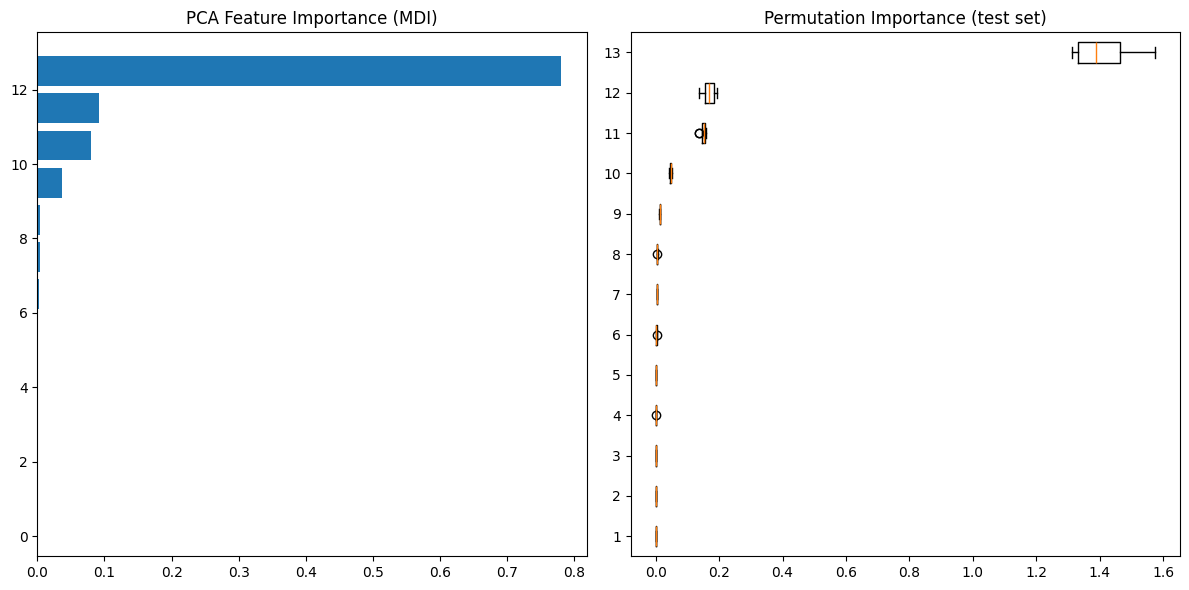

In [99]:
# Adpated from 
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html

feature_importance = gb_regressor.feature_importances_
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + 0.5

plot_feature_importance, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.barh(pos, feature_importance[sorted_idx], align="center")
ax1.set_title("PCA Feature Importance (MDI)")

result = permutation_importance(
    gb_regressor, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

ax2.boxplot(result.importances[sorted_idx].T, vert=False)
ax2.set_title("Permutation Importance (test set)")
plot_feature_importance.tight_layout()
plot_feature_importance.savefig(f'{images_path}/GBR_feature_importance.png')

## Gradient boost regression as a good fit

R2 score is 0.92 without scaling. This is quite good.

R2 score is 0.93 with y-scaling. Marginally better.

Moving to a Deep Neural Network model to try and improve performance.

The predicted vs actual plot do not appear to have a different shape than the model results


# Building a pipeline

In [ ]:
p_skew_fix = ColumnTransformer(transformers=[('yeo_johnson', PowerTransformer, skewed)],
                               remainder= 'passthrough')
pipe_gbr = Pipeline(steps = [('fix_skew', p_skew_fix),
                         ('std_scaler', StandardScaler()),
                         ('gb_regressor', GradientBoostingRegressor)])

NameError: name 'df_ohe_encoded' is not defined


# Neural Network Model

In [ ]:
dim_input = X_test.shape[1]
dim_output = y.shape[1]
print("Xdim", dim_input,"| ydim", dim_output)

Xdim 13 | ydim 1


In [ ]:
# https://machinelearningmastery.com/multi-label-classification-with-deep-learning/

# input
layers = [Dense(16, activation='relu'),
          # fork model to predict hardness
          Dense(units=16, activation='relu'),
        #Dense(units=64, activation='relu'),
        #Dense(units=64, activation='relu'),
          # Output layers for each label
          Dense(dim_output, name='Hardness')
]

nn_model = Sequential(layers)

nn_model.compile(optimizer=optimizers.Adam(0.0005),
                 loss='mean_absolute_error',
                 metrics=['mse'])

nn_history = nn_model.fit(x=X_train, y=y_train, 
                        verbose=0, 
                        epochs=100,
                        validation_split = 0.2)


In [ ]:
nn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_100 (Dense)               │ (None, 16)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hardness (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,541 (6.02 KB)

 Trainable params: 513 (2.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,028 (4.02 KB)

## Evaluate NN model

Inital NN model is slightly worse than a gradient boosted regression

In [ ]:
result = nn_model.evaluate(X_test, y_test, return_dict=True)
result

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1986 - mse: 0.0785  


{'loss': 0.19504918158054352, 'mse': 0.07439492642879486}

In [ ]:
history_df = pl.DataFrame(nn_history.history)
history_df = history_df.with_row_index()
history_df.tail(3)

index,loss,mse,val_loss,val_mse
u32,f64,f64,f64,f64
97,0.159185,0.052888,0.202895,0.092532
98,0.158132,0.052332,0.202805,0.09352
99,0.157897,0.052111,0.204349,0.093904


In [ ]:
def plot_model_history(df, name='DNN', feature='mse', tuner=False):
    title = f'{feature}'.title() if feature != 'mse' else "Mean Squared Error"
    selector = ['index', feature]
    if tuner: selector.append(f'val_{feature}')

    df_reduced = df.select(selector)

    plot = alt.Chart(df_reduced).mark_line().encode(
        alt.X('index').title('Epochs'),
        alt.Y(alt.repeat('layer'), type='quantitative').\
            title(title),
        color = alt.datum(alt.repeat('layer'))
    ).repeat(
        layer = selector[1:]
    ).properties(title=f"{title} by Epoch")

    plot.show()

    plot.save(f"{images_path}/{name}_{feature}.png")


In [ ]:
plot_model_history(history_df, feature='mse', name="initial_NN", tuner=True)
plot_model_history(history_df, feature='loss', name="initial_NN", tuner=True)

alt.RepeatChart(...)

alt.RepeatChart(...)

# Results

NN model pushes R2 down to 0.5 with onyl about 25 epochs

# Build a Tuner

In [ ]:
def create_hp_model(hp):
    #Activation for all hidden layers
      activation = hp.Choice('activation',['relu','tanh','sigmoid'])

      layers = [Dense(units=hp.Int('time_units1',
                             min_value=8,
                             max_value=256,
                             sampling='linear'), 
                             activation=activation),
                             # fork model to predict hardness
                  Dense(units=hp.Int('time_units2',
                             min_value=8,
                             max_value=256,
                             sampling='linear'), 
                             activation=activation),
                  Dense(dim_output, name='Hardness')
          ]
    
      nn_model = Sequential(layers)

      nn_model.compile(optimizer=optimizers.Adam(0.01),
                 loss='mean_absolute_error',
                 metrics=['mse'])
    
      return nn_model

In [ ]:
name = "hardness_NNR_tuner"
tuner = kt.Hyperband(
    create_hp_model,
    objective=["val_loss","val_loss"],
    max_epochs=20,
    factor=5,
    hyperband_iterations=2,
    project_name=name,
    executions_per_trial=5)


Reloading Tuner from ./hardness_NNR_tuner/tuner0.json


In [ ]:
tuner.search(x=X_train, 
             y=y_train,
             epochs=250,
             validation_data=(X_test,y_test))

In [ ]:
best_model = tuner.get_best_models(1)[0]

/home/mox/Documents/coding_projects/bootcamp_local/Homeworks/Mild-Steel-Tempering/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
fit_history = best_model.fit(x=X_train, 
               y=y_train, 
               verbose=0,
               epochs=150)

In [ ]:
tuner.get_best_hyperparameters(1)[0].values

{'activation': 'relu',
 'time_units1': 189,
 'time_units2': 40,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0019'}

In [ ]:
history_df = pl.DataFrame(fit_history.history)
history_df = history_df.with_row_index()
history_df.head(3)

index,loss,mse
u32,f64,f64
0,0.387553,0.282624
1,0.227039,0.095939
2,0.201764,0.072412


In [ ]:
plot_model_history(history_df, feature='mse', name=name, tuner=False)
plot_model_history(history_df, feature='loss', name=name, tuner=False)

alt.RepeatChart(...)

alt.RepeatChart(...)

# Optimizing optimizer

In [ ]:

def create_opt_model(opt):
    #Activation for all hidden layers

    layers = [Dense(units=164, 
                    activation='relu'),
                Dense(units=24, 
                      activation='relu'),
                Dense(dim_output, name='Hardness')
          ]
    
    nn_model = Sequential(layers)

    nn_model.compile(optimizer=opt,
                 loss='mean_absolute_error',
                 metrics=['mse'])
    
    return nn_model

In [ ]:
opts = [name.lower() for name in ["Adadelta", 
                                        "Adafactor", 
                                        "Adagrad", 
                                        "Adam", 
                                        "AdamW", 
                                        "Adamax", 
                                        "Ftrl", 
                                        "Lion", 
                                        "Nadam", 
                                        "RMSprop", 
                                        "SGD"]]

In [ ]:
for opt in opts:
    best_opt = 'starter'
    best_mse = 4

    model = create_opt_model(opt)
    model.fit(x=X_train, 
            y=y_train,
            verbose=0,
            epochs=150)
    
    loss, mse = nn_model.evaluate(X_test, y_test)
    
    if mse < best_mse:
        best_mse = mse
        best_opt = opt

print("Best Optimizer:", best_opt, "with MSE", best_mse)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1986 - mse: 0.0785  
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 0.1986 - mse: 0.0785
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 0.1986 - mse: 0.0785
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 590us/step - loss: 0.1986 - mse: 0.0785
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step - loss: 0.1986 - mse: 0.0785
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 0.1986 - mse: 0.0785
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 0.1986 - mse: 0.0785
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 0.1986 - mse: 0.0785
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 0.1986 - mse: 0.0785
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 0.1986 - mse: 0.0785
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 461us/step - loss: 0.1986 - mse: 0.0785
Best Optimizer: sgd with MSE 0.07439492642879486


## Epoch optimization

In [ ]:
model = create_opt_model(optimizers.SGD(0.01))
fit = model.fit(x=X_train, 
         y=y_train, 
         verbose=0,
         epochs=100)



In [ ]:
name= 'epoch_test'
history_df = pl.DataFrame(fit.history)
history_df = history_df.with_row_index()
history_df
plot_model_history(history_df, feature='mse', name=name)
plot_model_history(history_df, feature='loss', name=name)

alt.RepeatChart(...)

alt.RepeatChart(...)

# Best Neural Network Model

In [ ]:
model = create_opt_model(opt)
fit = model.fit(x=X_train, 
        y=y_train,
        verbose=0,
        epochs=25)

history_df = pl.DataFrame(fit.history)
history_df = history_df.with_row_index()
history_df

plot_model_history(history_df, feature='mse', name=name)
plot_model_history(history_df, feature='loss', name=name)

alt.RepeatChart(...)

alt.RepeatChart(...)

In [ ]:
y_pred = model.predict(X_test)
print('R2 score:', r2_score(y_test, y_pred))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R2 score: 0.938721665526804


# Best model, GBR combined with a search

For the Purposes of building an engineering tool that would select the best tempering method to reach a desired hardness, a gradient boost regression should be used. 

From this dataset, an ensamble model would likely be most effective. Use a search tree tests to test pair predictions using the GBR model. This search would uses the predicted hardness difference from the desired hardness as a metric to settle on a set of tempering conditions. 

It is outside the scope of this project, but the XGB model is much less computationally expensive and just as accuracte as the neural network models. An additional piece of infortmation to be fully condifent that would be the best solutions would be to find the worst case search scenario, and how many GBR tests are done. No other system explored here would give satisfactory results however.

In [ ]:
print("R2 score:", round(gb_regressor.score(X_test, reshape_y_for_eval(y_test)),3))

R2 score: 0.928


In [ ]:
plot_gbr_fit

alt.LayerChart(...)

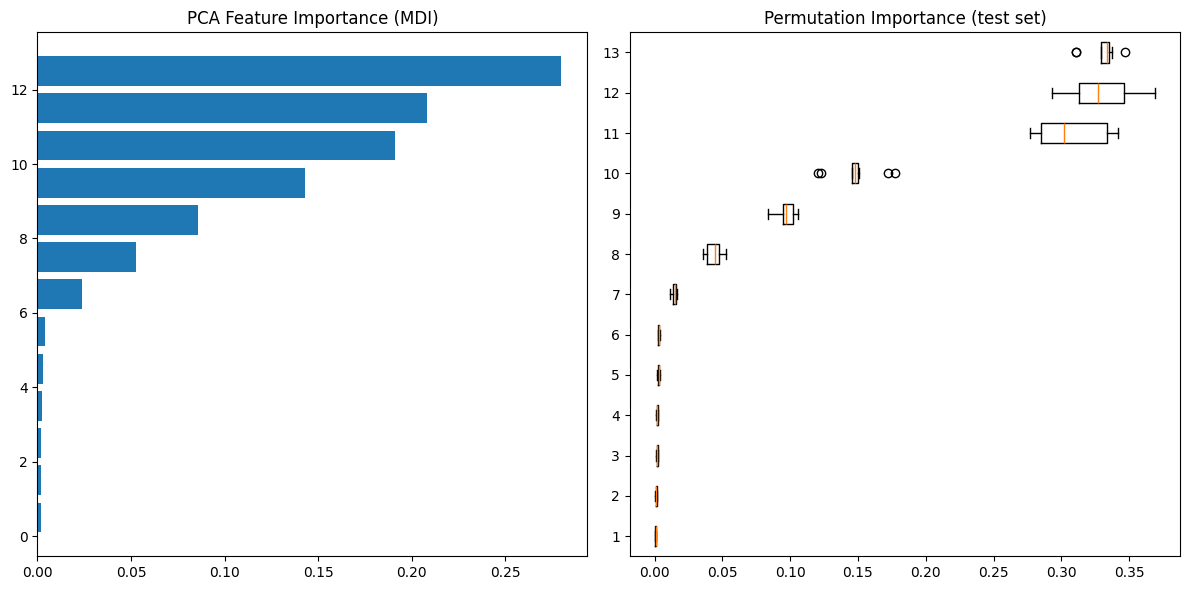

In [ ]:
plot_feature_importance